# Multiple comparisons of treatment means

## 1. Introduction

Data from many experiments are analyzed using analysis of variance. If results indicate a statistical difference between treatment means, the next step is to identify where the differences lie. The ideal situation is to decide what comparisons will be made during experimental design. The comparisons should be independant, no more than the treatment degrees of freedom and have a concrete meaning in terms of experiment structure. If other comparisons are found to be significant, they should ideally be investigated in a further experiment.

## 2. Treatments with no structure

If there is no structure in the experiment, it is tempting to to perform pairwise comparisons of all treatment means.  The number of comparisons for $t$ treatment levels is $t(t-1)/2$. If there are 10 treatment levels, 45 comparisons will be made. If two random treatment levels are chosen and their means differ by more than the 5% LSD, we reject the hypothesis that the means are the same with a type I error of 5%. If the difference between the two means is smaller than the 5% LSD while in fact the treatments are different, we fail to reject the null hypothesis when it is false and commit a type II error. If we reduce the type I error by using the 1% LSD, we automatically increase the type II error. The probability of the type II error is $\beta$. $\beta - 1$ is the power of the test, the probability to reject the null hypothesis when it is false. The power of the test can be increased without increasing the type I error by increasing the number of replication. It is acceptable to use the LSD test for comparisons planned in advance, but not to do comparisons suggested by the data. For example, if the LSD test is used to compare the highest and the lowest means, the type I error is higher than 5%.

We will identify 5% of all our comparisons as significantly different will there is no difference, this is the **comparison-wise error rate**. The **experiment-wise error rate** is the probability of dectecting at least one significant difference in our experiment and is calculated as $1 - (1 - 0.05)^c$ where c is the number of comparisons that are performed.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from itertools import chain
from itertools import repeat
from scipy.stats import f
from scipy.stats import t
from scipy.stats import probplot
from scipy.optimize import curve_fit
from statsmodels.stats.libqsturng import qsturng #Q values of studentised range
from statsmodels.stats.libqsturng import psturng #p-values of studentised range
from itertools import repeat
from itertools import chain

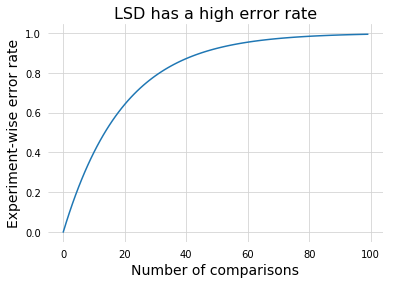

In [2]:
#plot of the experiment-wise error rate depending on the number of comparisons performed

#number of comparisons
c = np.array(list(range(100)))

#experiment-wise error rate
ewer = 1 - (1 - 0.05) ** c

#plot
fig, ax = plt.subplots()
ax.plot(c, ewer)
ax.set_xlabel('Number of comparisons', fontsize=14)
ax.set_ylabel('Experiment-wise error rate', fontsize=14)
ax.set_title('LSD has a high error rate', fontsize=16)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
plt.show()

The problem with the LSD test is the high experiment-wise error rate. Other tests have been developed to control this. They are not as powerful as the LSD test, as they do not detect as many differences that are real. We will present the LSD test as a reference, then the other tests. 

In our example, six varieties are replicated four times using a randomised block design.

In [3]:
varieties = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

#number of replication per variety
n = 4

#residual degrees of freedom
resid_df = 15

#variety means
means = np.array([50.8, 69.2, 25, 89, 76.2, 74])
means_tup = [('V1', 50.8), ('V2', 69.2), ('V3', 25), ('V4', 89), ('V5', 76.2), ('V6', 74)]

#residual mean square
resid_ms = 144.45

#standard error of difference between two means
sed = np.sqrt(2 * resid_ms / n)

### 2.1 Least significant difference

The least significant difference at the 5% level is: 
$$LSD \thinspace(5\%)=t_{(15,\thinspace 2.5\%)} \times SED$$

Some protection against making a high type I error is afforded by user the **Fisher's protected LSD** procedure. This is the same as the ordinary LSD test but no comparisons are made if the F-test used to test the null hypothesis of equal treatment effects shows a non-significant result.

In [4]:
#dataframe of differences of means
diff = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#dataframe of p-values from LSD test of differences of means
p_lsd = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#loop over means to calculate difference and perform LSD test
for i in range(len(means) - 1):
    for j in range(i, len(means) - 1):
        difference = means[j + 1] - means[i]
        diff.iloc[i, j] = difference
        p_lsd.iloc[i, j] = 1 - t.cdf(abs(difference) / sed, resid_df)
        
print('Differences of means')
print(diff, '\n\n')
print('p-values (LSD test)')
print(p_lsd, '\n\n')

Differences of means
      V2    V3    V4    V5    V6
V1  18.4 -25.8  38.2  25.4  23.2
V2   NaN -44.2  19.8     7   4.8
V3   NaN   NaN    64  51.2    49
V4   NaN   NaN   NaN -12.8   -15
V5   NaN   NaN   NaN   NaN  -2.2 


p-values (LSD test)
           V2           V3           V4           V5           V6
V1  0.0234566   0.00417061  0.000213813   0.00459028   0.00775028
V2        NaN  5.37841e-05    0.0170962     0.211515     0.290278
V3        NaN          NaN  8.99106e-07  1.16357e-05  1.86416e-05
V4        NaN          NaN          NaN    0.0763988    0.0489532
V5        NaN          NaN          NaN          NaN     0.399628 




### 2.2 Tukey's Honestly Significant Difference (HSD) test

In the LSD test, the experiment-wise error rate increases as the number of treatments increases. The HSD test controls the experiment-wise error rate. For any given level of significance, a minimum significant difference(MSD) is calculated using the studentised range distribution. It is greater than the corresponding LSD. Whereas the LSD does not depend on the number of treatments, MSD increases with the number of treatments. 

$$MSD = Q \times \sqrt{\frac{RMS}{r}} = 4.595 \times \sqrt{\frac{144.54}{4}} = 27.62$$

To calculate Studentised range Q and p values we use `qsturng` and `psturng` function from `statsmodels.stats.libqsturng` with n = 6 (the number of means we compare) and df = 15 (the residual degrees of freedom).

In [5]:
#dataframe of p-values from HSD test of differences of means
p_hsd = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#loop over means to perform an HSD test
for i in range(len(means) - 1):
    for j in range(i, len(means) - 1):
        q = abs(means[j + 1] - means[i]) / np.sqrt(resid_ms / 4)
        p_hsd.iloc[i, j] = psturng(q, 6, 15)
        
print('Differences of means')
print(diff, '\n\n')
print('p-values (HSD test)')
print(p_hsd, '\n\n')

Differences of means
      V2    V3    V4    V5    V6
V1  18.4 -25.8  38.2  25.4  23.2
V2   NaN -44.2  19.8     7   4.8
V3   NaN   NaN    64  51.2    49
V4   NaN   NaN   NaN -12.8   -15
V5   NaN   NaN   NaN   NaN  -2.2 


p-values (HSD test)
          V2          V3          V4         V5        V6
V1  0.308349   0.0739432  0.00468076  0.0804718  0.126227
V2       NaN  0.00123635    0.241727        0.9       0.9
V3       NaN         NaN       0.001      0.001     0.001
V4       NaN         NaN         NaN   0.649066  0.512556
V5       NaN         NaN         NaN        NaN       0.9 




### 2.3 Student-Newman-Keuls (SNK) test

This is a multiple-range test intermediate in power between the LSD and the HSD tests. For comparing the largest versus the smallest mean it is equivalent to Tukey's test. For comparing means of adjacent magnitude it is equivalent to the LSD test. Let's go through the SNK procedure step by step. More declarations of significance are made with this test than using Tukey's test, but fewer than with the LSD test.

In [6]:
#arrange t means in order of magnitude
means_sort = np.argsort(means)

#calculate MSD t - 1 times for t, t - 1, ... 2 means
snk = []
for treat in range(len(means), 1, -1):
    snk.append(qsturng(0.95, treat, resid_df) * np.sqrt(resid_ms / 4))
#snk = snk[::-1]

print('Original mean order: ', means_tup)
print('Sorted means: ', sorted(means))
print('SNK values: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}\n\n'.format(*snk))
    
#compare the highest and lowest means using SNK(t)
print('=== Comparison of SNK values to differences of means ===\n')
print('SNK(6): {:.2f}'.format(snk[0]))
print('Difference of highest and lowest mean : {:.2f}'.format(sorted(means)[5] - sorted(means)[0]))
print('V3 and V4 are significantly different\n')

#compare the two ranges of t - 1 adjacent ranked means with SNK(t - 1)
print('SNK(5): {:.2f}'.format(snk[1]))
print('Differences of (t - 1) range means: {:.2f} and {:.2f}'.format(sorted(means)[4] - sorted(means)[0],
                                                                     sorted(means)[5] - sorted(means)[1]))
print('V3 and V5 are significantly different, V1 and V4 are significantly different\n')

#compare the two ranges of t - 2 adjacent ranked means with SNK(t - 2)
print('SNK(4): {:.2f}'.format(snk[2]))
print('Differences of (t - 2) range means: {:.2f} and {:.2f}'.format(sorted(means)[3] - sorted(means)[0],
                                                                     sorted(means)[5] - sorted(means)[2]))
print('V3 and V6 are significantly different, but V2 and V4 are not significantly different\n')

#compare one range of t - 3 ranked means with SNK(t - 3)
#we do not compare means between V2 and V4 as their difference is not significant
print('SNK(3): {:.2f}'.format(snk[3]))
print('Differences of (t - 3) range means: {:.2f}'.format(sorted(means)[2] - sorted(means)[0]))
print('V3 and V2 are significantly different\n')

#compare one range of t - 4 ranked means with SNK(t - 4)
print('SNK(2): {:.2f}'.format(snk[4]))
print('Differences of (t - 4) range means: {:.2f}'.format(sorted(means)[1] - sorted(means)[0]))
print('V3 and V1 are significantly different\n')

Original mean order:  [('V1', 50.8), ('V2', 69.2), ('V3', 25), ('V4', 89), ('V5', 76.2), ('V6', 74)]
Sorted means:  [25.0, 50.8, 69.2, 74.0, 76.2, 89.0]
SNK values: 27.61, 26.25, 24.50, 22.07, 18.11


=== Comparison of SNK values to differences of means ===

SNK(6): 27.61
Difference of highest and lowest mean : 64.00
V3 and V4 are significantly different

SNK(5): 26.25
Differences of (t - 1) range means: 51.20 and 38.20
V3 and V5 are significantly different, V1 and V4 are significantly different

SNK(4): 24.50
Differences of (t - 2) range means: 49.00 and 19.80
V3 and V6 are significantly different, but V2 and V4 are not significantly different

SNK(3): 22.07
Differences of (t - 3) range means: 44.20
V3 and V2 are significantly different

SNK(2): 18.11
Differences of (t - 4) range means: 25.80
V3 and V1 are significantly different



### 2.4 Duncan's multiple range test (DMRT)

This test was once very popular but now most statisticians warn against its use because it does not control the type I experiment-wise error sufficiently. It is very similar to the SNK test except the critical ranges are smaller. These ranges are calculated by the same formula as for the SNK test but a special table is used instead of the Studentised range table. It is more powerful than the SNK test but also has a higher type I error.

### 2.5 Waller-Duncan's Bayes MSD test

In this test, all possible pairs of means are compared by calculating a minimum significant difference (MSD) whose value depends on the result of the F-test in the ANOVA. The higher the variance ratio (VR), the smaller the critical MSD, thereby increasing the power of the test. If the VR is small (indicating little overall difference), the MSD is increased, making it less likely that two means will be declared significant. The advantage of this test is that it is almost as powerful as the ordinary LSD but does not suffer from having a high type I experiment-wise error.

### 2.6 Summary of multiple-comparison tests

The number of significant differences between two means were as follows: LSD(10), Tukey(5), SNK(9), DMR(10), WDB(10). There is no consensur on which test is best, it is a tradeoff between making a type I and a type II error.

### 2.7 Least significant increase (LSI)

In many experiments, treatments are compared with a standard. In a plant breeding trial, we would look for new variety which give higher yield or quality than the standards. For this purpose, we can use the LSI procedure which is the one-sided version of LSD. It consists of a series of one-tailed t-tests. If each variety is equally replicated, a single LSD value can be used and the formula for the tests at the 5% level is:

$$LSI = t_{(Rdf, \thinspace 5\%)} \times \sqrt{\frac{2 \times RMS}{r}} = t_{(Rdf, \thinspace 5\%)} \times SED$$

where $Rdf$ is the residual degrees of freedom and RMS is the residual mean square from the ANOVA table. Let's compare the means of our previous example.

In [7]:
#calculate the least significant increase
lsi = t.ppf(0.95, resid_df) * sed

#determine if test varieties outyield the standard V1
print("Least Significant Increase at 5% level.\n'True' if variety outyields V1, 'False' otherwise.")
diff.loc['V1'] >= lsi

Least Significant Increase at 5% level.
'True' if variety outyields V1, 'False' otherwise.


V2     True
V3    False
V4     True
V5     True
V6     True
Name: V1, dtype: bool

### 2.8 One-sided confidence intervals

Confidence intervals give more information than significance tests. We calculate the confidence interval for the increase in mean yields compared to the standard variety and subtract LSI. We are then 95% confident that a variety outyields V1 by their difference in means minus LSI.

In [8]:
#calculate one-sided confidence intervals
print("One-sided confidence interval.\nWe are 95% confident the varieties outyield V1 by the following values.")

#we filter the results to remove varieties with lower yield
(diff.loc['V1'] - lsi)[diff.loc['V1'] >= lsi]

One-sided confidence interval.
We are 95% confident the varieties outyield V1 by the following values.


V2    3.50165
V4    23.3017
V5    10.5017
V6    8.30165
Name: V1, dtype: object

## 3. Treatments with structure (factorial structure)

Let's consider the following set of treatments:
* T1 : no fertiliser applied to variety A
* T2 : potassium applied to variety A
* T3 : no fertiliser applied to variety B
* T4 : potassium applied to variety B
* T5 : nitrogen applied to variety A
* T6 : nitrogen and potassium applied to variety A
* T7 : nitrogen applied to variety B
* T8 : nitrogen and potassium applied to variety B

These eight treatments posses a $2^3$ factorial structure, because each factor has two levels.

In [9]:
#yields in a tidy dataframe
var = ['A'] * 4 + ['B'] * 4
K = list(chain(*map(lambda i: repeat(i, 2), range(2)))) * 2
Ni = [0, 1] * 4
mean_yields = [4.3, 5.2, 4.7, 5.8, 4.8, 6.4, 7.4, 7.4]
tidy = pd.DataFrame({'Variety':var, 'Nitrogen':Ni, 'Potassium':K, 'Yield':mean_yields})

In [10]:
#treatment means
treat = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8']
yields = pd.DataFrame({'Mean yield':[4.3, 4.7, 4.8, 7.4, 5.2, 5.8, 6.4, 7.4]}, index=treat)
print('Yields of the treatments\n')
print(yields, '\n\n')

#print preliminary anova table
source = ['blocks', 'treatments', 'residual', 'total']
df = [3, 7, 21, 31]
ss = [27.55, 41.12, 7.59, 76.26]
ms = [9.18, 5.87, 0.36, 'nan']
vr = ['nan', 16.3, 'nan', 'nan']
anova_tb = pd.DataFrame({'Source':source, 'df':df, 'Sum sq':ss, 'Mean sq':ms, 'VR':vr})
cols = ['Source', 'df', 'Sum sq', 'Mean sq', 'VR']
anova_tb = anova_tb[cols]
print('Preliminary ANOVA table\n')
print(anova_tb, '\n\n')

#print detailed anova table
source = ['Variety', 'Nitrogen', 'V x N', 'Potassium', 'K x V', 'K x N', 'K x V x N', 'Treatment']
df = [1, 1, 1, 1, 1, 1, 1, 7]
ss = [18, 6.48, 0.08, 10.58, 3.38, 0.98, 1.62, 41.12]
ms = [18, 6.48, 0.08, 10.58, 3.38, 0.98, 1.62, 5.87]
vr = [50, 18, 0.22, 29.4, 9.4, 2.7, 4.5, 16.3]
p_vals = []
for i in range(len(vr)):
    p_vals.append(1 - f.cdf(vr[i], df[i], 21))
anova_tb = pd.DataFrame({'Source':source, 'Sum sq':ss, 'Mean sq':ms, 'VR':vr, 'P':p_vals})
cols = ['Source', 'Sum sq', 'Mean sq', 'VR', 'P']
anova_tb = anova_tb[cols]
print('ANOVA table showing partitioning of treatment sum of squares and degrees of freedom\n')
print(anova_tb, '\n\n')

Yields of the treatments

    Mean yield
T1         4.3
T2         4.7
T3         4.8
T4         7.4
T5         5.2
T6         5.8
T7         6.4
T8         7.4 


Preliminary ANOVA table

       Source  df  Sum sq Mean sq    VR
0      blocks   3   27.55    9.18   nan
1  treatments   7   41.12    5.87  16.3
2    residual  21    7.59    0.36   nan
3       total  31   76.26     nan   nan 


ANOVA table showing partitioning of treatment sum of squares and degrees of freedom

      Source  Sum sq  Mean sq     VR             P
0    Variety   18.00    18.00  50.00  5.613976e-07
1   Nitrogen    6.48     6.48  18.00  3.637160e-04
2      V x N    0.08     0.08   0.22  6.438728e-01
3  Potassium   10.58    10.58  29.40  2.227620e-05
4      K x V    3.38     3.38   9.40  5.865066e-03
5      K x N    0.98     0.98   2.70  1.152382e-01
6  K x V x N    1.62     1.62   4.50  4.596304e-02
7  Treatment   41.12     5.87  16.30  3.488065e-07 




The values of VR for the main effects and interactions are calculated by dividing the corresponding mean square values by the residual mean square (0.36) from the preliminary ANOVA table. An F-value can be calculated on 1 and 21 degrees of freedom.

The three-factor interaction (K x V x N) is significant. We can conclude that two factors interact differently at each level of the third factor. From the graphs below, we can see that the effect of N is similar at both levels of K for variety A. For variety B the effect of N is large in absence of N but has no effect in the presence of K. The SED for testing these effects is the SED for comparing any two means, it is calculated as:

$$SED_{V \times K \times N} = \sqrt{\frac{2 \times RMS}{r}} = \sqrt{\frac{2 \times 0.36}{4}} = 0.42$$

The ANOVA table suggests there are large main effects, but it can be misleading to quote them when there are significant interactions.

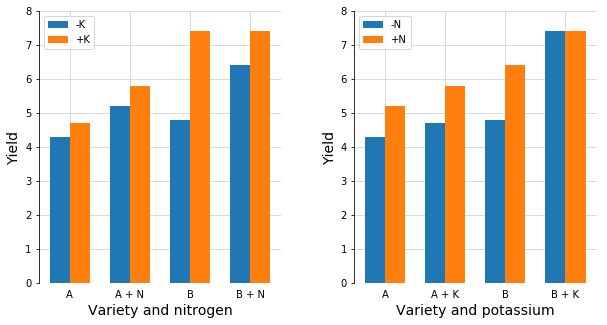

In [11]:
#graphical presentation of results, with two possibilities

#import patch for legend elements
from matplotlib.patches import Patch

#plot yields on two grouped barplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

pos = list(range(4))
width = 1 / 3

#plots
ax1.bar(pos, yields.loc[['T1', 'T5', 'T3', 'T7']].values.flatten(), width, zorder=4, label='-K')
ax1.bar([p + width for p in pos], yields.loc[['T2', 'T6', 'T4', 'T8']].values.flatten(), width, zorder=4, label='+K')

ax2.bar(pos, yields.loc[['T1', 'T2', 'T3', 'T4']].values.flatten(), width, zorder=4, label='-N')
ax2.bar([p + width for p in pos], yields.loc[['T5', 'T6', 'T7', 'T8']].values.flatten(), width, zorder=4, label='+N')

#put legend on subplot 1
ax1.legend()

#put legend on subplot 2
ax2.legend()

#remove spines
for spine in ['top', 'bottom', 'right']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

#put grid
ax1.grid(color='lightgrey')
ax2.grid(color='lightgrey')

#remove x ticks and labels
ax1.tick_params(axis='x', color='white')
ax2.tick_params(axis='x', color='white')
ax1.set_xticks([p + width / 2 for p in pos])
ax2.set_xticks([p + width / 2 for p in pos])
ax1.set_xticklabels(['A', 'A + N', 'B', 'B + N'])
ax2.set_xticklabels(['A', 'A + K', 'B', 'B + K'])
ax1.set_xlabel('Variety and nitrogen', fontsize=14)
ax2.set_xlabel('Variety and potassium', fontsize=14)

#adjust y axis
ax1.set_ylim(0, 8)
ax2.set_ylim(0, 8)
ax1.set_ylabel('Yield', fontsize=14)
ax2.set_ylabel('Yield', fontsize=14)

plt.subplots_adjust(wspace=0.3)
plt.show()

If the three-factor interaction had not been significant we would present the K x V table of means (see below) as this interaction was highly significant (p-value = 0.0059). The SED for comparing two of these means is:

$$SED_{K \times V} = \sqrt{\frac{2 \times RMS}{r}} = \sqrt{\frac{2 \times 0.36}{8}} = 0.3$$

with r = 8 since each K x V mean is the average of 8 original yields. For variety A, the potassium effect is small (+0.5) while for variety B it is high (+1.8).

In [12]:
#show variety x potassium yields
tidy.groupby(['Variety', 'Potassium'])['Yield'].mean()

Variety  Potassium
A        0            4.75
         1            5.25
B        0            5.60
         1            7.40
Name: Yield, dtype: float64

There was no two-factor interaction with nitrogen (see p-values of ANOVA table), so if the three-factor interaction had not been significant the overall nitrogen means would also have been presented. The SED for comparing these two means is:

$$SED_N = \sqrt{\frac{2 \times RMS}{16}} = 0.21$$

since each nitrogen mean is the average of 16 original yields.

In [13]:
#show nitrogen yields
tidy.groupby('Nitrogen')['Yield'].mean()

Nitrogen
0    5.3
1    6.2
Name: Yield, dtype: float64

In summary, in a three-factor experiment there are three one-way tables of means, three two-way tables and one three-way table. Each of these seven tables has its own SED value. The tables we will present depend on which main effects and interaction are significant. Beware of using main effect SEDs to compare main effect means in the presence of significant interaction.

## 4. Treatments with structure (levels of a quantitative factor)

The treatments in an experiment could be different levels on a fertiliser such as nitrogen or potassium. Thus, a factorial experiment may contain a mixture of quantitative and qualitative factors. For example, in a 2 x 5 factorial experiment, the two levels of factor A may be two varieties and the five levels of factor B may be different concentration of a nitrogen fertiliser. In this case, the main interest would be in discovering if the response to nitrogen varied with variety. A graph showing the two response curves would be appropriate. We may fit straight lines or curves describing the responses. Let's begin by studying a single-factor experiment.

### 4.1 Testing for a linear trend in treatment means

As there are several Y values for each X, an estimate of the residual variance ($\sigma^2$) can be obtained from the preliminary analysis of variance table. This table is modified by partitioning the treatment sum of squares into a part due to linear regression and a part due to deviation from regression. The modified table is used to test for the linear trend.

Our example is an experiment testing the effects of six levels of nitrogen fertiliser between 0 and 125 kg/ha on winter wheat. A randomised block design with four replications was used. The grain yields are shown below in a tidy dataframe. Let's perform a linear regression on yields *versus* nitrogen fertiliser quantity.

In [14]:
#yields of winter wheat depending on nitrogen fertiliser
yields = [3.6, 4.8, 4.4, 5.3, 4.8, 5.0, 
          4.1, 5.1, 5.2, 5.9, 5.5, 5.4, 
          3.2, 4.0, 4.6, 4.6, 5.2, 4.8,
          3.9, 3.9, 4.8, 5.0, 5.1, 4.6]
blocks = list(chain(*map(lambda i: repeat(i, 6), range(1, 5))))
nitrogen = list(range(0, 150, 25)) * 4
df = pd.DataFrame({'blocks': blocks, 'nitrogen':nitrogen, 'yield':yields})
print(df, '\n')
print(df.groupby(['nitrogen'])['yield'].mean())

    blocks  nitrogen  yield
0        1         0    3.6
1        1        25    4.8
2        1        50    4.4
3        1        75    5.3
4        1       100    4.8
5        1       125    5.0
6        2         0    4.1
7        2        25    5.1
8        2        50    5.2
9        2        75    5.9
10       2       100    5.5
11       2       125    5.4
12       3         0    3.2
13       3        25    4.0
14       3        50    4.6
15       3        75    4.6
16       3       100    5.2
17       3       125    4.8
18       4         0    3.9
19       4        25    3.9
20       4        50    4.8
21       4        75    5.0
22       4       100    5.1
23       4       125    4.6 

nitrogen
0      3.70
25     4.45
50     4.75
75     5.20
100    5.15
125    4.95
Name: yield, dtype: float64


We should not use a linear regression on all 24 values because we need to use the variation in the Y values for each X (after allowing for block effects) to estimate the residual variance ($\sigma^2$). This is the residual mean square in the preliminary analysis of variance shown below, and is used to test for a linear trend in the modified table shown after.

The nitrogen sum of squares (6.320) represents the variation in the treatment means after allowing for blocks. **Part of this variation is due to the regression** (NitroSS = RegSS + DeviationSS). 

The regression sum of squares (4.4251) is obtained from the regression analysis on all 24 yields. The sum of squares due to deviation from regression represents part of the nitrogen sum of squares not accounted for by linear regression. It is obtained by subtracting (NitroSS - RegSS = 1.8949). The ANOVA table shows the partitioning of nitrogen sum of squares.

#### Interpretetion
From the ANOVA table we can see that nitrogen means are significantly different (VR = 16.21, p-value < 0.001). A significant amount of the variation in the means is due to a linear trend (VR = 56.73, p-value < 0.001). The corresponding t-value is 7.53 (the square root of 56.73) on 15 df. This contrasts with that obtained with only the means (3.06 on 4 df, cf the linear regression notebook) or the 24 yields (4.30 on 22 df, not shown).

Under nitrogen contrasts, the slope is shown as 0.0101. To obtain the **standard error of the slope** (0.00134) divide the slope by the t-value of 7.53. The sum of squares of all X values is also shown (43750). It is also four times the Sxx value of the six separate nitrogen levels because each X value is repeated four times. The **standard error of the slope** can also be calculated as the square root of the residual mean square divided by the sum of squares of all X values:

$$SE = \sqrt{\frac{RMS}{Sxx}}$$

The **R-square** value is $R-sq = RegSS / NitroSS = 4.42514 / 6.32 = 0.7 \thinspace (70\%)$. This is the same as obtained when only the six means were used in the analysis (cf linear regression notebook). Note also that because each mean is calculated from four yields, the RegSS is four times that obtained with six means.

The low p-value (0.004) for the deviations variance ratio shows a lack of fit to a straight line, indicating that a significant amount of variation between the treatment means is not explained by linear regression and we should look for a different relationship.

RegSS <= NitroSS. If RegSS = NitroSS this implies that the treatment means lie exactly on a straight line. However, this does not imply a significant regression as the individual values could be widely scattered, as shown by the size of the sum of squares. In this case the R-square value calculated using RegSS / NitroSS would be 100% whereas that based on all values (RegSS / TotalSS) would be low. In our example, these two values are 70% and 45.7% respectively.

In [15]:
def factorial_anova(data=None, variate=None, block=None, factors=None):
    """Perform an ANOVA on an experiment with a factorial design.
    
    data : tidy dataframe (each row is an observation, each column is a variable)
    
    variate : name of the column of the dataframe containing the response variable
    
    block : name of the column of the dataframe containing block numbers
    
    factors : list of factor names
    """
    
    #===========================================#
    #=== sample sizes and degrees of freedom ===#
    #===========================================#

    #total number of observations
    N = len(data)

    #number of blocks
    n_block = len(set(data[block]))

    #number of treatments
    n_treat = len(set(data[factors]))

    #regression and deviations
    reg_df = 1
    dev_df = n_treat - 1 - reg_df
        
    #residual degrees of freedom
    resid_df = N - n_block - (n_treat - 1)
    
    #=========================#
    #=== linear regression ===#
    #=========================#
    
    x = data[factors].values
    y = data[variate].values
    
    #corrected sum of products Sxy
    Sxy = np.sum(x * y) - np.sum(x) * np.sum(y) / len(x)

    #corrected sum of squares of X
    Sxx = np.sum(x ** 2) - np.sum(x) ** 2 / len(x)

    #calculation of the parameters of the regression line y = a * x + b
    b = Sxy / Sxx
    a = np.mean(y) - b * np.mean(x)
    
    #calculate fitted y values
    y_hat = np.array([a + b * i for i in x])

    #=======================================#
    #=== sum of squares and mean squares ===#
    #=======================================#

    #total sum of and mean squares
    total_ss = data[variate].var(ddof=1) * (N - 1)

    #block sum of and mean squares
    block_ss = data.groupby(block).sum()[variate].var() * (n_block - 1) / (N / n_block)
    block_ms = block_ss / (n_block - 1)
    
    #list of factors sum of squares and mean squares
    fact_ss = data.groupby(factors).sum()[variate].var() * (n_treat - 1) / (N / n_treat)
    fact_ms = fact_ss / (n_treat - 1)
    
    #regression and deviations sum of squares and mean squares
    reg_ss = np.sum((y_hat - np.mean(y)) ** 2)
    reg_ms = reg_ss / reg_df
    dev_ss = fact_ss - reg_ss
    dev_ms = dev_ss / dev_df

    #residual sum of squares
    resid_ss = total_ss - block_ss -  fact_ss
    resid_ms = resid_ss / resid_df
    
    #=======================#
    #=== standard errors ===#
    #=======================#
    
    #standard error of the slope
    slope_se = np.sqrt(resid_ms / Sxx)
    
    #standard error of the difference of means
    sed = np.sqrt(2 * resid_ms / (N / n_treat))

    #====================================#
    #=== variance ratios and p-values ===#
    #====================================#
    vr_block = block_ms / resid_ms
    p_block = 1 - f.cdf(vr_block, n_block - 1, resid_df)
    
    #list of variance ratios for factors
    vr_fact = fact_ms / resid_ms
    
    #list of p-values for factors
    p_fact = 1 - f.cdf(vr_fact, n_treat - 1, resid_df)
        
    #regression and deviations
    vr_reg = reg_ms / resid_ms
    p_reg = 1 - f.cdf(vr_reg, reg_df, resid_df)
    vr_dev = dev_ms / resid_ms
    p_dev = 1 - f.cdf(vr_dev, dev_df, resid_df)
    
    #=====================#
    #=== print results ===#
    #=====================#
    
    #print ANOVA
    print('=== Analysis of variance ===\n')
    print('Response variable: ', variate, '\n')
    print('{0:<12}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'VR', 'p-value'))
    print('-' * 62)
    if block != None:
        print('\n{0:<12}{1:>10}{2:>10.3f}{3:10.3f}{4:>10.3f}{5:>10.5f}\n'.format('block', n_block - 1, block_ss,
                                                                                 block_ms, vr_block, p_block))
    print('{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format(factors, n_treat - 1, fact_ss, fact_ms, vr_fact,
                                                                          p_fact))
    print("{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}".format("  regression", reg_df, reg_ss, reg_ms, vr_reg, 
                                                                          p_reg))
    print("{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}".format("  deviations", dev_df, dev_ss, dev_ms, vr_dev, 
                                                                          p_dev))
    print('{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}'.format('residual', resid_df, resid_ss, resid_ms))
    print('\n{0:<12}{1:>10}{2:>10.3f}\n\n'.format('total', N - 1, total_ss))
    
    #print nitrogen contrasts
    print('=== {} contrasts ===\n'.format(factors))
    print('slope {0:.5f}    s.e. {1:.5f}    Sxx {2:.3f}\n\n'.format(a, slope_se, Sxx))
    
    #print standard error of difference of means
    print('=== Standard error of the difference of means ===\n')
    print('{0:<10}{1:>10}'.format('', variate))
    print('{0:<10}{1:>10}'.format('rep.', N // n_treat))
    print('{0:<10}{1:>10}'.format('df', resid_df))
    print('{0:<10}{1:>10.4f}'.format('sed', sed))

In [16]:
factorial_anova(data=df, block='blocks', variate='yield', factors='nitrogen')

=== Analysis of variance ===

Response variable:  yield 

Source              df    Sum sq   Mean sq        VR   p-value
--------------------------------------------------------------

block                3     2.190     0.730     9.359   0.00099

nitrogen             5     6.320     1.264    16.205   0.00001
  regression         1     4.425     4.425    56.733   0.00000
  deviations         4     1.895     0.474     6.073   0.00411
residual            15     1.170     0.078

total               23     9.680


=== nitrogen contrasts ===

slope 4.07143    s.e. 0.00134    Sxx 43750.000


=== Standard error of the difference of means ===

               yield
rep.               4
df                15
sed           0.1975


### 4.2 Testing for a quadratic trend in treatment means

A quadratic curve has already been fitted to the means of our example (cf. curve fitting notebook) and the regression sum of squares is 1.557. As each mean is based on four values this figure is multiplied by four to give the quadratic model regression sum of squares for all 24 points as $RegSS(Quad) = 6.2226$ on 2 df. This values can also be obtained by fitting the quadratic model on all 24 points.

The deviation sum of squares from the quadratic model is:

$$DevSS(Quad) = TreatSS - RegSS(Quad) = 6.2300 - 6.2262 = 0.0938 \: on \: (5 - 2) = 3 \: df$$

From the previous output it is seen that the linear regression model sum of squares for the 24 points is $RegSS(Lin) = 4.425$ on 1 df. Hence, the extra sum of squares due to quadratic over and above linear regression is 6.2262 - 4.4251 = 1.8011 on 1 df.

To test if a quadratic curve is significantly better than a straight line, we find:

$$VR = \frac{RegSS(Quad) - RegSS(Lin)}{RMS} = \frac{1.8011}{0.0780}=23.09 \: on \: (1, 15) \: df$$

This corresponds to a low p-value so we conclude that a quadratic curve is a better fit than a straight line.

#### Interpretation
Note that an extra row (quad) has been added to the output. This shows that when a quadratic model is fitted the regression sum of squares is 1.8011 greater than when a linear model is fitted. This increase is significant since the associated p-value is 0.00023. The regression sum of squares for the quadratic model is found by adding the values for the linear and quadratic rows (6.2262).

Note also that the entries in the deviations row have been changed. This shows that the sum of squares due to lack of fit from the quadratic model is 0.0938 and not significant (VR = 0.40 and p-value = 0.754). Hence the quadratic curve adequately explains the variation in mean yields.

This method makes the homogeneity of variance assumption, that at each nitrogen level the variance of the residuals is constant. The plot of values shows this is a valid assumption.

The R-square value is obtained by dividing RegSS(Quad) by TreatSS to obtain 0.985. This compares with 0.70 using the linear model. This value reflects the fit of the treatment means to a quadratic curve. While the fit is almost perfect there may be considerable variation within treatments. To obtain the appropriate value for the 24 data points ignoring the treatment and block structure, divide RegSS(Quad) by the total sum of squares to obtain 0.643.

In [21]:
def factorial_anova_quad(data=None, variate=None, block=None, factors=None):
    """Perform an ANOVA on an experiment with a factorial design, performs linear
    regression then quadratic regression.
    
    data : tidy dataframe (each row is an observation, each column is a variable)
    
    variate : name of the column of the dataframe containing the response variable
    
    block : name of the column of the dataframe containing block numbers
    
    factors : list of factor names
    """
    
    #===========================================#
    #=== sample sizes and degrees of freedom ===#
    #===========================================#

    #total number of observations
    N = len(data)

    #number of blocks
    n_block = len(set(data[block]))

    #number of treatments
    n_treat = len(set(data[factors]))

    #regression and deviations
    reg_df = 1
    
    #to account for quadratic regression we subtract reg_df twice
    dev_df = n_treat - 1 - reg_df - reg_df
        
    #residual degrees of freedom
    resid_df = N - n_block - (n_treat - 1)
    
    #=========================#
    #=== linear regression ===#
    #=========================#
    
    x = data[factors].values
    y = data[variate].values
    
    #corrected sum of products Sxy
    Sxy = np.sum(x * y) - np.sum(x) * np.sum(y) / len(x)

    #corrected sum of squares of X
    Sxx = np.sum(x ** 2) - np.sum(x) ** 2 / len(x)

    #calculation of the parameters of the regression line y = a * x + b
    b = Sxy / Sxx
    a = np.mean(y) - b * np.mean(x)
    
    #calculate fitted y values
    y_hat_lin = np.array([a + b * i for i in x])
    
    #============================#
    #=== quadratic regression ===#
    #============================#

    #define quadratic function
    def parabola(x, a, b, c):
        return a + b * x + c * x ** 2

    #fit quadratic curve on yields
    popt, pcov = curve_fit(parabola, df['nitrogen'], df['yield'])

    #fitted values
    y_hat_quad = parabola(df['nitrogen'], *popt)

    #residual sum of squares
    resid_ss = np.sum((df['yield'] - y_hat_quad) ** 2)

    #=======================================#
    #=== sum of squares and mean squares ===#
    #=======================================#

    #total sum of and mean squares
    total_ss = data[variate].var(ddof=1) * (N - 1)

    #block sum of and mean squares
    block_ss = data.groupby(block).sum()[variate].var() * (n_block - 1) / (N / n_block)
    block_ms = block_ss / (n_block - 1)
    
    #list of factors sum of squares
    treat_ss = data.groupby(factors).sum()[variate].var() * (n_treat - 1) / (N / n_treat)
    treat_ms = treat_ss / (n_treat - 1)
    
    #regression and deviations sum of squares and mean squares
    #for linear regression
    reg_lin_ss = np.sum((y_hat_lin - np.mean(y)) ** 2)
    reg_lin_ms = reg_lin_ss / reg_df
    
    #for quadratic regression
    reg_quad_ss = np.sum((y_hat_quad - np.mean(y)) ** 2)
    reg_quad_ms = reg_quad_ss / reg_df
    dev_ss = treat_ss - reg_quad_ss
    dev_ms = dev_ss / dev_df

    #extra sum of squares due to quadratic regression above linear regression
    extra_ss = reg_quad_ss - reg_lin_ss
    extra_ms = extra_ss / reg_df

    #residual sum of squares
    resid_ss = total_ss - block_ss -  treat_ss
    resid_ms = resid_ss / resid_df
    
    #================#
    #=== R-square ===#
    #================#
    Rsq = reg_quad_ss / total_ss
    
    #=======================#
    #=== standard errors ===#
    #=======================#
    
    #standard error of the slope
    slope_se = np.sqrt(resid_ms / Sxx)
    
    #standard error of the difference of means
    sed = np.sqrt(2 * resid_ms / (N / n_treat))

    #====================================#
    #=== variance ratios and p-values ===#
    #====================================#
    vr_block = block_ms / resid_ms
    p_block = 1 - f.cdf(vr_block, n_block - 1, resid_df)
    
    #list of variance ratios for treatments
    vr_treat = treat_ms / resid_ms
    
    #list of p-values for treatments
    p_treat = 1 - f.cdf(vr_treat, n_treat - 1, resid_df)
        
    #for regressions and deviations
    vr_reg_lin = reg_lin_ms / resid_ms
    vr_reg_quad = (reg_quad_ms - reg_lin_ss) / resid_ms
    p_reg_lin = 1 - f.cdf(vr_reg_lin, reg_df, resid_df)
    p_reg_quad = 1 - f.cdf(vr_reg_quad, reg_df, resid_df)
    vr_dev = dev_ms / resid_ms
    p_dev = 1 - f.cdf(vr_dev, dev_df, resid_df)
    
    #=====================#
    #=== print results ===#
    #=====================#
    
    #print ANOVA
    print('=== Analysis of variance ===\n')
    print('Response variable: ', variate, '\n')
    print('{0:<12}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'VR', 'p-value'))
    print('-' * 62)
    if block != None:
        print('\n{0:<12}{1:>10}{2:>10.3f}{3:10.3f}{4:>10.3f}{5:>10.5f}\n'.format('block', n_block - 1, block_ss,
                                                                                 block_ms, vr_block, p_block))
    print('{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format(factors, n_treat - 1, treat_ss, treat_ms, vr_treat,
                                                                          p_treat))
    print("{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}".format("  linear", reg_df, reg_lin_ss, reg_lin_ms, 
                                                                          vr_reg_lin, p_reg_lin))
    print("{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}".format("  quadratic", reg_df, extra_ss, extra_ms,
                                                                          vr_reg_quad, p_reg_quad))
    print("{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}".format("  deviations", dev_df, dev_ss, dev_ms, vr_dev, 
                                                                          p_dev))
    print('{0:<12}{1:>10}{2:>10.3f}{3:>10.3f}'.format('residual', resid_df, resid_ss, resid_ms))
    print('\n{0:<12}{1:>10}{2:>10.3f}\n\n'.format('total', N - 1, total_ss))
    
    print('=== Goodness of fit ===\n')
    print('R-square: {:.3f}\n\n'.format(Rsq))
    
    #print nitrogen contrasts
    print('=== {} contrasts ===\n'.format(factors))
    print('linear {0:.5f}    s.e. {1:.5f}    Sxx {2:.3f}'.format(a, slope_se, Sxx))
    print('quadratic {0:.5f}    s.e. ???    ss.div. ???'.format(popt[2]))
    
    #=================#
    #=== PLOT DATA ===#
    #=================#
    fig, ax = plt.subplots()
    
    #plot actual data
    ax.scatter(x, y, zorder=5, label='Observed')
    
    #plot fitted data
    xx = np.linspace(min(x) - 1, max(x) + 1)
    y_fit = parabola(xx, *popt)
    ax.plot(xx, y_fit, color='C3', zorder=4, label='Fitted')
    
    #adjut visualisation
    ax.set_xlabel(factors, fontsize=14)
    ax.set_ylabel(variate, fontsize=14)
    ax.set_title('Polynomial regression', fontsize=16)
    ax.tick_params(axis='both', color='white')
    for axis in ['top', 'bottom', 'right', 'left']:
        ax.spines[axis].set_visible(False)
    ax.grid(linewidth=0.5, color='lightgrey', zorder=3)
    ax.legend(loc='lower right')

=== Analysis of variance ===

Response variable:  yield 

Source              df    Sum sq   Mean sq        VR   p-value
--------------------------------------------------------------

block                3     2.190     0.730     9.359   0.00099

nitrogen             5     6.320     1.264    16.205   0.00001
  linear             1     4.425     4.425    56.733   0.00000
  quadratic          1     1.801     1.801    23.091   0.00023
  deviations         3     0.094     0.031     0.401   0.75447
residual            15     1.170     0.078

total               23     9.680


=== Goodness of fit ===

R-square: 0.643


=== nitrogen contrasts ===

linear 4.07143    s.e. 0.00134    Sxx 43750.000
quadratic -0.00018    s.e. ???    ss.div. ???


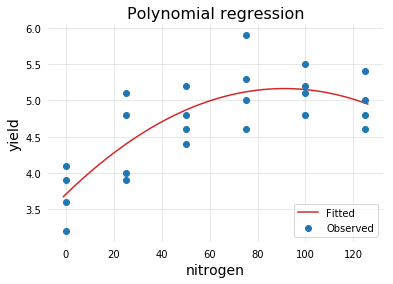

In [22]:
factorial_anova_quad(data=df, variate='yield', block='blocks', factors='nitrogen')